# Mango dmc

In [29]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mtply
import scipy.io as sp_io

plt.rcParams.update({'font.size': 12})


from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import functions as func
import caltransfer_local as ct
from sample_selection import sample_selection

from utils_format  import get_mod_performance


In [2]:
data_url = "NAnderson2020MendeleyMangoNIRData.csv"

data_raw = pd.read_csv(data_url,sep = ",", decimal = ".")
data_raw.describe(include = 'all')

Set        Season Region        Date        Type Cultivar  \
count   11691  11691.000000  11691       11691       11691    11691   
unique      3           NaN      2          46           2       10   
top       Cal           NaN     NT  23/10/2017  Hard Green     Caly   
freq     7413           NaN   8141        1198        9711     3460   
mean      NaN      2.337696    NaN         NaN         NaN      NaN   
std       NaN      1.068196    NaN         NaN         NaN      NaN   
min       NaN      1.000000    NaN         NaN         NaN      NaN   
25%       NaN      1.000000    NaN         NaN         NaN      NaN   
50%       NaN      3.000000    NaN         NaN         NaN      NaN   
75%       NaN      3.000000    NaN         NaN         NaN      NaN   
max       NaN      4.000000    NaN         NaN         NaN      NaN   

                 Pop   Temp            DM      285  ...     1173     1176  \
count   11691.000000  11691  11691.000000  11691.0  ...  11691.0  11691.0   
unique           NaN      4           NaN      NaN  ...      NaN      NaN   
top              NaN     No           NaN      NaN  ...      NaN      NaN   
freq             NaN   7318           NaN      NaN  ...      NaN      NaN   
mean       49.379608    NaN     16.282835      0.0  ...      0.0      0.0   
std        33.796239    NaN      2.459531      0.0  ...      0.0      0.0   
min         1.000000    NaN      9.464606      0.0  ...      0.0      0.0   
25%        14.000000    NaN     14.332756      0.0  ...      0.0      0.0   
50%        52.000000    NaN     16.301700      0.0  ...      0.0      0.0   
75%        76.000000    NaN     18.112985      0.0  ...      0.0      0.0   
max       112.000000    NaN     24.577150      0.0  ...      0.0      0.0   

           1179     1182     1185     1188     1191     1194     1197     1200  
count   11691.0  11691.0  11691.0  11691.0  11691.0  11691.0  11691.0  11691.0  
unique      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
top         NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
freq        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
mean        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
std         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
min         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
25%         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
50%         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
75%         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
max         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[11 rows x 315 columns]

In [3]:
pd.crosstab([data_raw.Region,data_raw.Type, data_raw.Season, data_raw.Cultivar], 
                             data_raw.Set, margins = False)

Set                                 Cal  Tuning  Val Ext
Region Type       Season Cultivar                       
NT     Hard Green 1      Caly      1277     158        0
                         HG         293     276        0
                         KP        1059       0        0
                  2      Caly       300      80        0
                         HG           0      88        0
                         KP         340      92        0
                         R2E2       276      10        0
                  3      1201       318      80        0
                         1243       320      80        0
                         4069        80     320        0
                         Caly       156     164        0
                         HG          80      80        0
                         KP         216      80        0
                         LadyG      158     190        0
                         LadyJ      238     160        0
                         R2E2       156     236        0
                  4      Caly         0       0       80
                         KP           0       0       80
                         R2E2         0       0       80
       Ripen      3      KP          78       0        0
                  4      Caly         0       0      144
                         KP           0       0      158
                         R2E2         0       0      160
QLD    Hard Green 1      Caly       160      80        0
                         HG          80      80        0
                         KP          80      80        0
                         Keitt      211      80        0
                  2      Caly        40       0        0
                         HG          38       0        0
                         Keitt       40       0        0
                         R2E2        39      20        0
                  3      Caly       264       0        0
                         HG          80      80        0
                         KP         180       0        0
                         R2E2       158       0        0
                  4      Caly         0       0       80
                         HG           0       0       80
                         KP           0       0       80
                         R2E2         0       0       80
       Ripen      3      Caly       238      80        0
                         HG         226      78        0
                         KP           0      80        0
                         R2E2       234      78        0
                  4      Caly         0       0      159
                         HG           0       0      159
                         R2E2         0       0      108

# Source and target domains

In [4]:
source_name = "Season 1 / Caly"
target_name = "Season 3-4 / R2E2"
y_name = "DMC"

In [5]:
sou_filter = (data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "Caly")

tar_filters = []

# season 3
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))

# season 4
tar_test_filter = (data_raw["Set"]=="Val Ext") & (data_raw["Region"] == "NT") & ((data_raw["Type"] == "Hard Green") ) & ((data_raw["Cultivar"] == "R2E2"))

# data sizes
print(sou_filter.sum(), [tt_filter.sum() for tt_filter in tar_filters],tar_test_filter.sum())

1277 [156] 80


In [6]:
# Get data sets for each domain

data_sou = data_raw.loc[sou_filter]
data_tar_list = []

for tt_filter in tar_filters:
    
    data_tar_list.append(data_raw.loc[tt_filter])
    
data_tar_test = data_raw.loc[tar_test_filter]




In [7]:
# Get matrices for each domain

wv_range_selected = np.arange(130,220)#np.arange(40,265) # 430-1100 nm

Xsou_all = np.array(data_sou.iloc[:,17:-14])[:,wv_range_selected]
Ysou_all = np.array(data_sou.iloc[:,8:9])

Xt_list = []
Yt_list = []

for data_tar in data_tar_list:
    
    Xt_list.append(np.array(data_tar.iloc[:,17:-14])[:,wv_range_selected])
    Yt_list.append(np.array(data_tar.iloc[:,8:9]))


Xtar_test = np.array(data_tar_test.iloc[:,17:-14])[:,wv_range_selected]
Ytar_test = np.array(data_tar_test.iloc[:,8:9])


wv_range = np.array(data_sou.columns[17:-14]).astype(np.float64)[wv_range_selected]


# spectral signals from each domain

ymin = -0.7
ymax = 0.5








In [8]:
# split cal-test 

my_sample_selection = sample_selection(Xsou_all, ncp = 20) # 20 is just a large number of pc's  
my_sample_selection.get_xcal_pca_scores()
soucal_samples = my_sample_selection.duplex(Nout = int(0.8*Xsou_all.shape[0]), use_pca_scores=True, distance_metric='mahalanobis') == 1
# soucal_samples = my_sample_selection.random_sample(Nout = int(0.8*Xsou_all.shape[0])) == 1 # any selection would be ok
soutest_samples = soucal_samples == 0

Xsou_cal = Xsou_all[soucal_samples,:]
Ysou_cal = Ysou_all[soucal_samples,:]

Xsou_test = Xsou_all[soutest_samples,:]
Ysou_test = Ysou_all[soutest_samples,:]




In [9]:
Xtar_cal = Xt_list[0].copy()
Ytar_cal = Yt_list[0].copy()

# Summary statistics

In [11]:
desc = {}

desc["wv_min"] = np.amin(wv_range)
desc["wv_max"] = np.amax(wv_range)
desc["source_cal_n"] = Xsou_cal.shape[0]
desc["source_test_n"] = Xsou_test.shape[0]
desc["target_cal_n"] = Xtar_cal.shape[0]
desc["target_test_n"] = Xtar_test.shape[0]


desc["source_cal_mean"] = Ysou_cal.mean(axis=0) 
desc["source_test_mean"] = Ysou_test.mean(axis=0)
desc["target_cal_mean"] = Ytar_cal.mean(axis=0)
desc["target_test_mean"] = Ytar_test.mean(axis=0)


desc["source_cal_std"] = Ysou_cal.std(axis=0) 
desc["source_test_std"] = Ysou_test.std(axis=0)
desc["target_cal_std"] = Ytar_cal.std(axis=0)
desc["target_test_std"] = Ytar_test.std(axis=0)


desc_format = {}
# desc_format["index"] = 0
desc_format["Property"] = y_name
desc_format["Wavelength range (nm)"] = "{:.0f}-{:.0f}".format(np.amin(wv_range), np.amax(wv_range))
desc_format["Source calibration set/ property (mean±std)"] = "{:d} / ({:.2f} +- {:.2f})".format(desc["source_cal_n"],desc["source_cal_mean"][0],desc["source_cal_std"][0])
desc_format["Source test set/ property (mean±std)"] ="{:d} / ({:.2f} +- {:.2f})".format(desc["source_test_n"],desc["source_test_mean"][0],desc["source_test_std"][0])
desc_format["Target orthogonalization set/ property (mean±std)"] ="{:d} / ({:.2f} +- {:.2f})".format(desc["target_cal_n"],desc["target_cal_mean"][0],desc["target_cal_std"][0])
desc_format["Target test set/ property (mean±std)"] ="{:d} / ({:.2f} +- {:.2f})".format(desc["target_test_n"],desc["target_test_mean"][0],desc["target_test_std"][0])


pd.DataFrame([desc_format])


print(pd.DataFrame([desc_format]).to_latex())

\begin{tabular}{lllllll}
\toprule
{} & Property & Wavelength range (nm) & Source calibration set/ property (mean±std) & Source test set/ property (mean±std) & Target orthogonalization set/ property (mean±std) & Target test set/ property (mean±std) \\
\midrule
0 &      DMC &               699-966 &                      1021 / (16.16 +- 2.35) &                256 / (16.35 +- 2.51) &                             156 / (14.71 +- 1.64) &                 80 / (16.05 +- 1.51) \\
\bottomrule
\end{tabular}



# Dataset

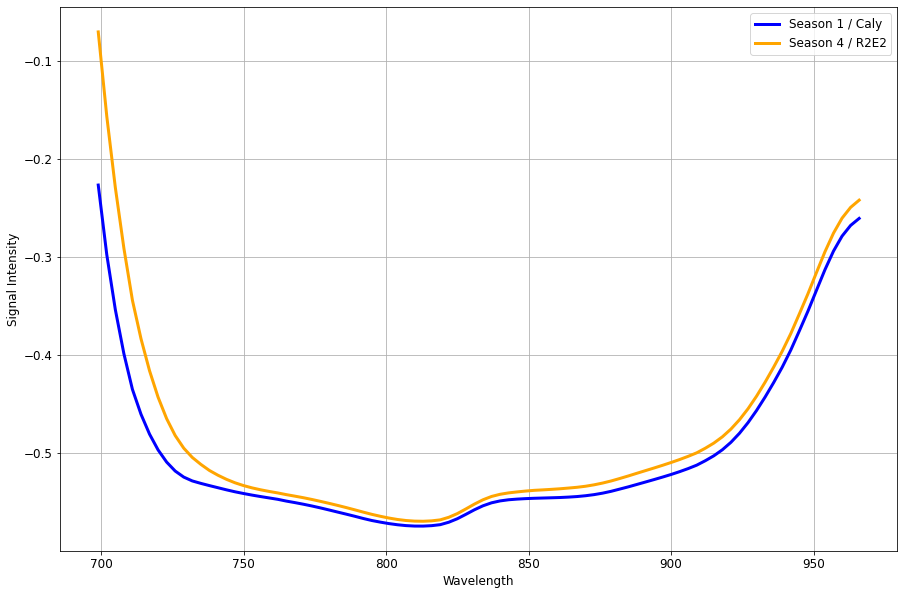

In [12]:
plt.subplots(figsize = (15, 10))
plt.plot(wv_range, Xsou_cal.mean(axis=0), c = "blue",  linewidth = 3, label = source_name)
plt.plot(wv_range, Xtar_cal.mean(axis=0), c = "orange", linewidth = 3, label = target_name)
plt.legend(loc = 0)
plt.xlabel("Wavelength")
plt.ylabel("Signal Intensity")
plt.grid()
plt.show()

# 1. Model building

# 1.1 Choosing number of components to orthogonalize

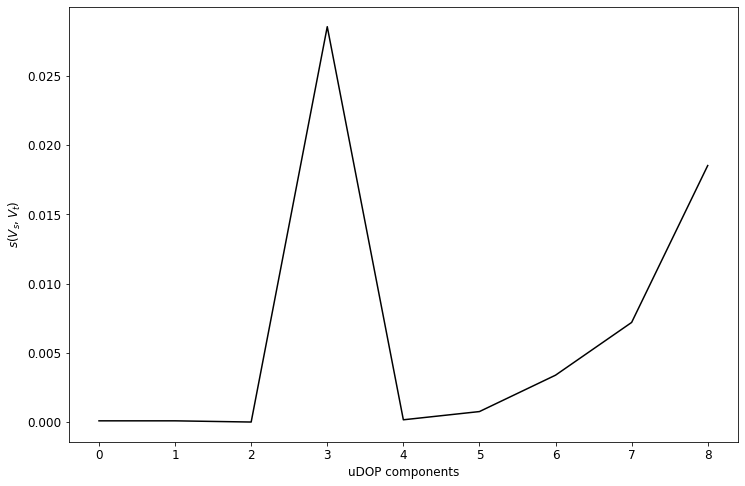

In [13]:

Xsou_cal_ms = Xsou_cal.copy()
Xtar_cal_ms = Xtar_cal.copy()
svd_ncomp = 10
udop_tune = 9
simil = np.zeros(udop_tune)


for ii in range(udop_tune):
    
    Xconcat = np.concatenate((Xsou_cal_ms, Xtar_cal_ms), axis = 0)
    
    E_udop = ct.udop(Xsou_cal_ms, Xtar_cal_ms, udop_ncomp=ii)
    

    Us0, Ss0, Vs_t0 = np.linalg.svd(Xsou_cal_ms - Xsou_cal_ms.mean(axis=0))
    Ut0, St0, Vt_t0 = np.linalg.svd(Xtar_cal_ms - Xtar_cal_ms.mean(axis=0))
    U0, S0, V_t0 = np.linalg.svd(Xconcat - Xconcat.mean(axis=0))


    
    Vs_t = Vs_t0[0:svd_ncomp,:]
    Vsou = Vs_t.T

    Vt_t = Vt_t0[0:svd_ncomp,:]
    Vtar = Vt_t.T
    
    
    V_t = V_t0[0:svd_ncomp,:]
    V = V_t.T


    Vsou_s = ct.Vsou_sign(Vsou, Vtar, V)
    
    simil[ii] = np.prod(np.abs(np.diag(Vsou_s.T.dot(Vtar))))


    Xsou_cal_ms = Xsou_cal_ms.dot(E_udop)
    Xtar_cal_ms = Xtar_cal_ms.dot(E_udop)

    
    
fig, ax = plt.subplots(figsize = (12, 8))
plt.plot(simil, c = "black")
plt.xlabel("uDOP components")
plt.ylabel(r'$s(V_s,V_t$)')
plt.show()


    



In [14]:
# 3 components

# 1. Model building: all orthogonalization strategies

In [15]:
rmse_min = 0.7
rmse_max = 1.1
total_lv = 20
n_splits_cv = 10

pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)


## 1.1 Original PLS model building

In [16]:
xcal_pls = Xsou_cal.copy()
ycal_pls = Ysou_cal.copy()

# 

In [17]:


rmsecv_original = np.zeros(total_lv)
r2cv_original = np.zeros(total_lv)

for lvi,lv in enumerate(range(1, total_lv+1)):    
    
    my_pls = PLSRegression(n_components = lv,scale=False)      
    ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = pls_cv)
    rmsecv_original[lvi] = np.sqrt(mean_squared_error(ycal_pls, ycal_cv))
    r2cv_original[lvi] = np.power(np.corrcoef(ycal_pls.T, ycal_cv.T)[0,1],2)
    


## 1.2 TOP PLS model building

In [18]:
E_top = ct.top((Xsou_cal, Xtar_cal), top_ncp = 1)
xcal_pls = Xsou_cal.dot(E_top).copy()


rmsecv_top = np.zeros(total_lv)
r2cv_top = np.zeros(total_lv)

for lvi,lv in enumerate(range(1, total_lv+1)):    
    
    my_pls = PLSRegression(n_components = lv,scale=False)      
    ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = pls_cv)
    rmsecv_top[lvi] = np.sqrt(mean_squared_error(ycal_pls, ycal_cv))
    r2cv_top[lvi] = np.power(np.corrcoef(ycal_pls.T, ycal_cv.T)[0,1],2)
    


## 1.3 DOP PLS model building

In [19]:
rho_range = np.array([1,2.5,5,7.5,10,30,50,75,100,175,250,375,500])
dop_range = np.array([3])
rho_range


array([  1. ,   2.5,   5. ,   7.5,  10. ,  30. ,  50. ,  75. , 100. ,
       175. , 250. , 375. , 500. ])

In [20]:


rmsecv_dop = np.zeros((total_lv, rho_range.shape[0], dop_range.shape[0]))
r2cv_dop = np.zeros((total_lv, rho_range.shape[0], dop_range.shape[0]))


for ri in range(rho_range.shape[0]):
    
    for di in range(dop_range.shape[0]):
        
        E_dop = ct.dop(Xsou_cal, Ysou_cal, Xtar_cal, Ytar_cal, rho=rho_range[ri], dop_ncomp=dop_range[di])
        xcal_pls = Xsou_cal.dot(E_dop).copy()       
        for lvi,lv in enumerate(range(1, total_lv+1)):    

            my_pls = PLSRegression(n_components = lv,scale=False)      
            ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = n_splits_cv)
            rmsecv_dop[lvi, ri, di] = np.sqrt(mean_squared_error(ycal_pls, ycal_cv))
            r2cv_dop[lvi, ri, di] = np.power(np.corrcoef(ycal_pls.T, ycal_cv.T)[0,1],2)



## 1.4 uDOP PLS model building

In [21]:

udop_range = np.array([3])


In [22]:


rmsecv_udop = np.zeros((total_lv, udop_range.shape[0]))
r2cv_udop = np.zeros((total_lv, udop_range.shape[0]))



for di in range(udop_range.shape[0]):

    E_udop = ct.udop(Xsou_cal, Xtar_cal, udop_ncomp=udop_range[di])
    xcal_pls = Xsou_cal.dot(E_udop).copy()

    for lvi,lv in enumerate(range(1, total_lv+1)):    

        my_pls = PLSRegression(n_components = lv,scale=False)      
        ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = pls_cv)
        rmsecv_udop[lvi, di] = np.sqrt(mean_squared_error(ycal_pls, ycal_cv))
        r2cv_udop[lvi, di] = np.power(np.corrcoef(ycal_pls.T, ycal_cv.T)[0,1],2)



## 1.5 Visualization of model building

In [23]:
#

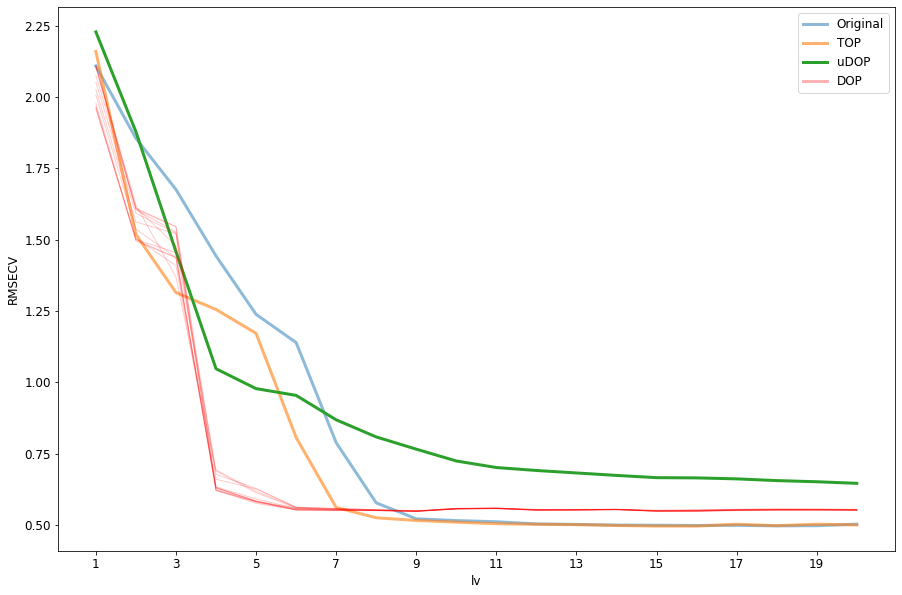

In [24]:



fig, ax = plt.subplots(figsize = (15, 10))


ax.plot(np.arange(1, total_lv+1), rmsecv_original, linewidth = 3, label= "Original", linestyle = "-", alpha = 0.5)
ax.plot(np.arange(1, total_lv+1), rmsecv_top, linewidth = 3, label= "TOP", linestyle = "-", alpha = 0.6)
ax.plot(np.arange(1, total_lv+1), rmsecv_udop[:,0], linewidth = 3, label="uDOP")
ax.plot(np.arange(1, total_lv+1), rmsecv_dop[:,1:,0], c = "red", linewidth = 1, linestyle = "-", alpha = 0.2)
ax.plot([], [],   c = "red",label= "DOP", linewidth = 3, linestyle = "-", alpha = 0.3)

ax.set_xticks(np.arange(1, total_lv+1,2))
ax.set_xlabel("lv")
ax.legend()
ax.set_ylabel("RMSECV")
plt.show()

## Chosen tuning parameters

In [25]:

original_lv_chosen = 9

top_lv_chosen = 8

udop_lv_chosen = 7
udop_comp_chosen = 3


dop_lv_chosen = 6
dop_rho_chosen = 10
dop_comp_chosen = 3




# 2. Final models performance 

In [26]:
table_summary_performance = {}

# 2.1 Fitting OP's

In [27]:
E_top = ct.top((Xsou_cal, Xtar_cal), top_ncp = 1)
E_dop = ct.dop(Xsou_cal, Ysou_cal, Xtar_cal, Ytar_cal, rho=dop_rho_chosen, dop_ncomp=dop_comp_chosen)
E_udop = ct.udop(Xsou_cal, Xtar_cal, udop_ncomp=udop_comp_chosen)

In [28]:
x_perf_s = 12.5
y_perf_s = 18
x_perf_t = 14
y_perf_t = 18


## 2.2 Original model

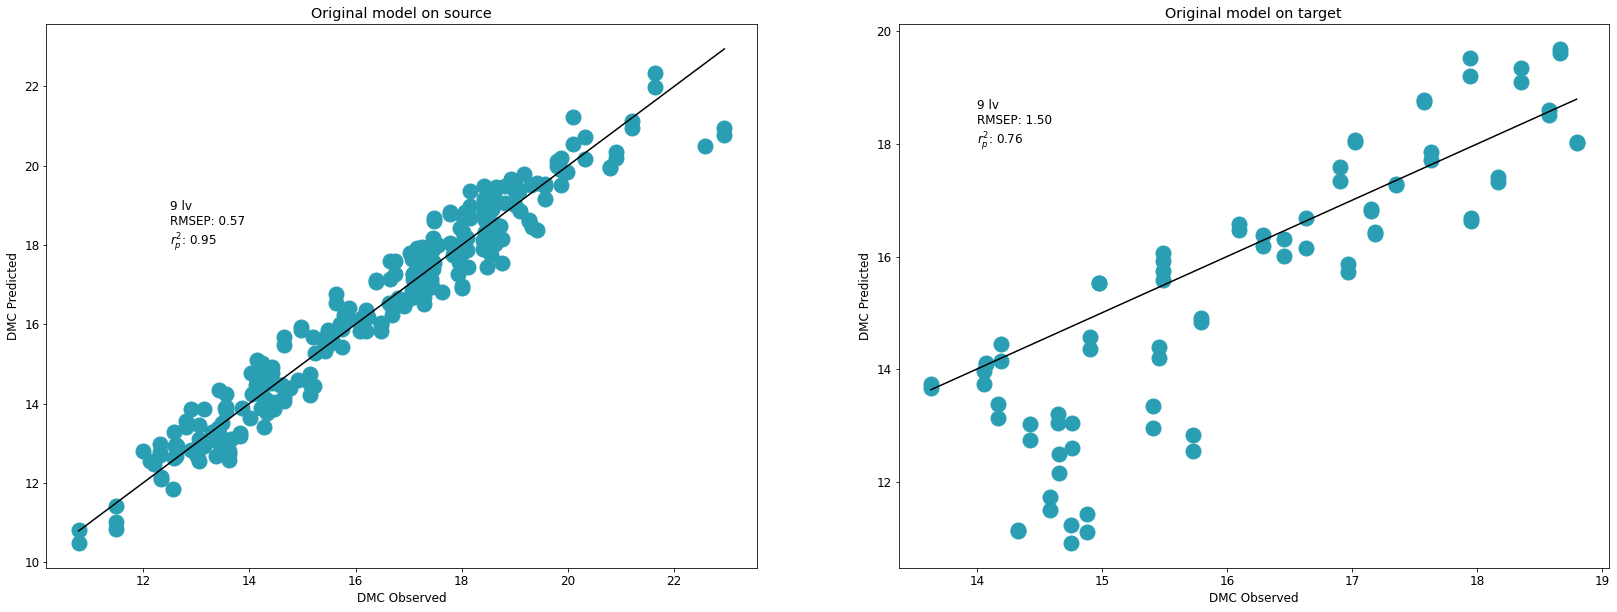

Property     Model Orthogonalization Parameters  LV RMSECV  R2CV  \
0      DMC  Original                         None   9   0.54  0.95   

  RMSEP (source) R2P (source) RMSEP (target) R2P (target)  
0           0.57         0.95           1.50         0.76

In [30]:

xcal_pls = Xsou_cal.copy()
chosen_lv = original_lv_chosen
orth_params = None
type_model = "Original"


model_performance_output = get_mod_performance(xcal_pls, ycal_pls, chosen_lv, Xsou_test, Ysou_test, Xtar_test, Ytar_test, 
                        type_model,x_perf_s,y_perf_s,x_perf_t,y_perf_t, n_splits_cv ,desc_format["Property"],orth_params,
                                              "", fig_width = 28)

table_summary_performance[type_model] = model_performance_output.copy()


pd.DataFrame([model_performance_output])


## 2.2 TOP model

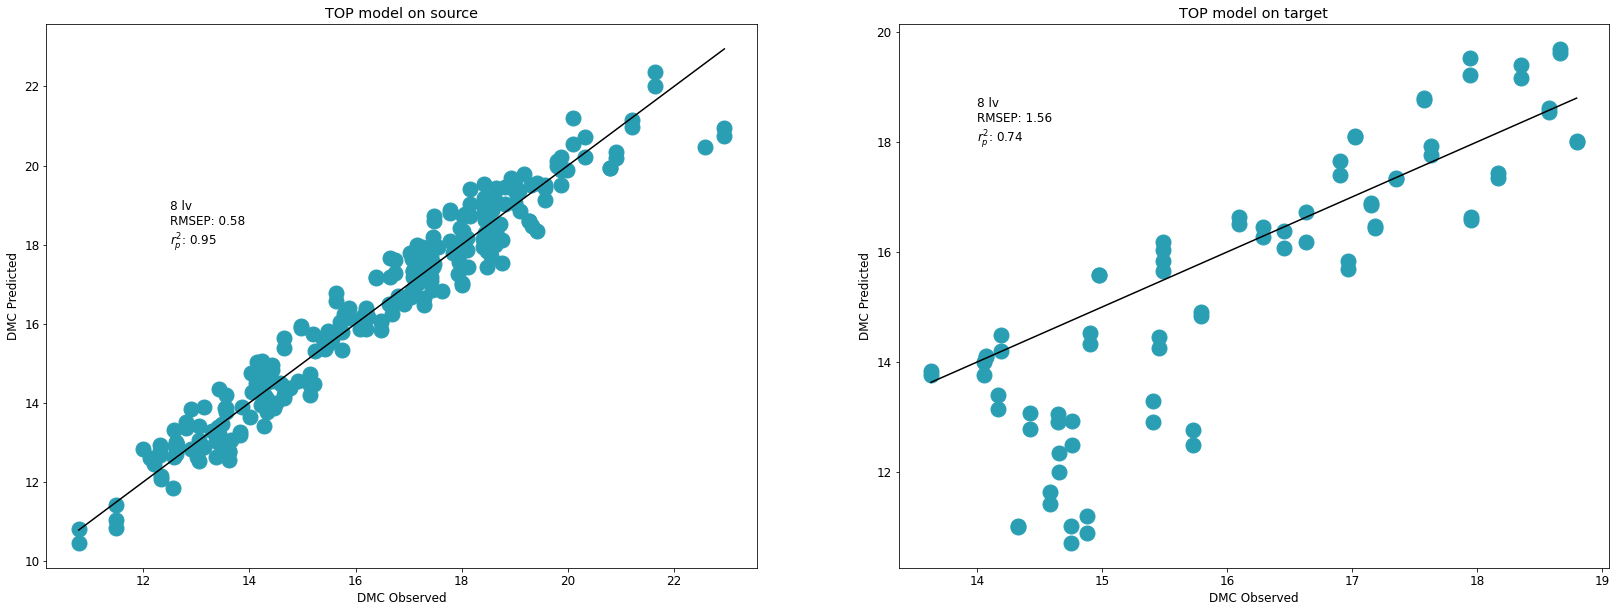

Property Model Orthogonalization Parameters  LV RMSECV  R2CV RMSEP (source)  \
0      DMC   TOP                       1 comp   8   0.54  0.95           0.58   

  R2P (source) RMSEP (target) R2P (target)  
0         0.95           1.56         0.74

In [31]:

xcal_pls = Xsou_cal.dot(E_top)
chosen_lv = top_lv_chosen
orth_params = "1 comp"
type_model = "TOP"

model_performance_output = get_mod_performance(xcal_pls, ycal_pls, chosen_lv, Xsou_test, Ysou_test, Xtar_test, Ytar_test, 
                        type_model,x_perf_s,y_perf_s,x_perf_t,y_perf_t, n_splits_cv , desc_format["Property"], orth_params,
                                              "", fig_width = 28)


table_summary_performance[type_model] = model_performance_output.copy()

pd.DataFrame([model_performance_output])

## 2.3 DOP model

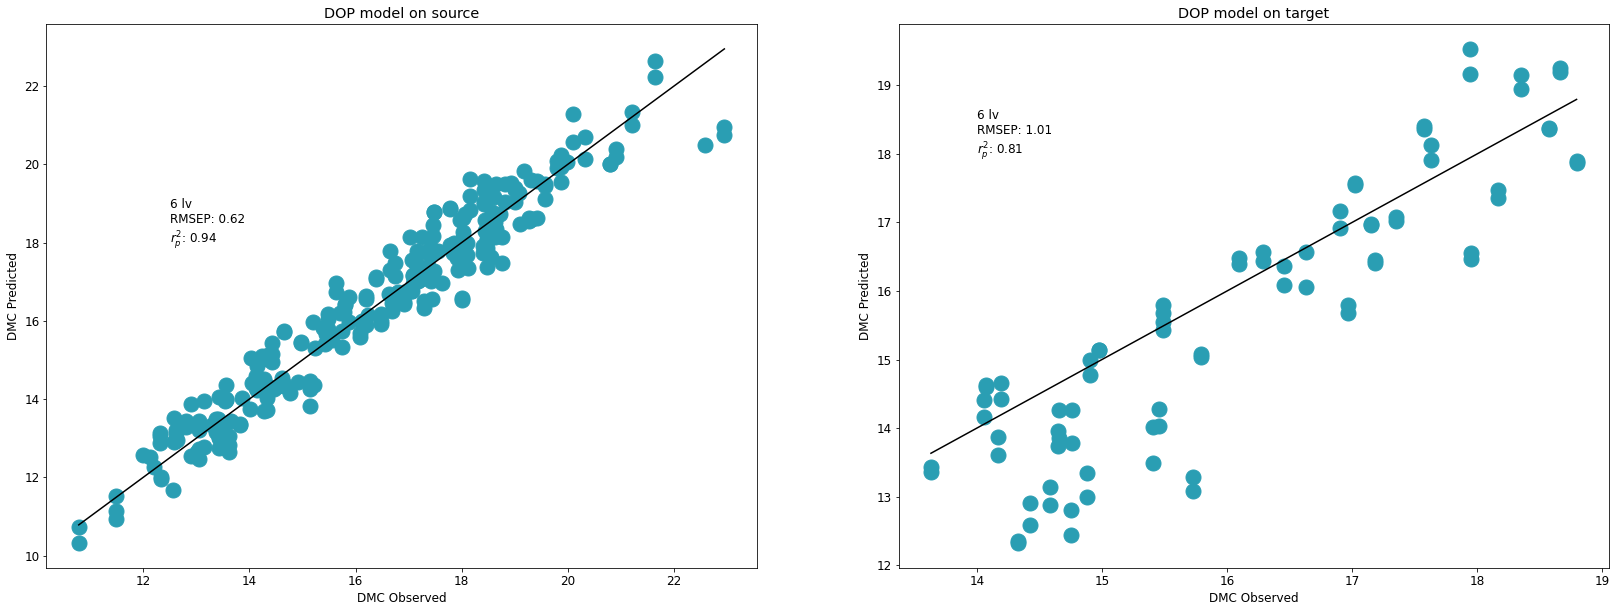

Property Model Orthogonalization Parameters  LV RMSECV  R2CV RMSEP (source)  \
0      DMC   DOP         $\rho$ : 10 / 3 comp   6   0.56  0.94           0.62   

  R2P (source) RMSEP (target) R2P (target)  
0         0.94           1.01         0.81

In [32]:

xcal_pls = Xsou_cal.dot(E_dop)
chosen_lv = dop_lv_chosen
orth_params = r'$\rho$ : {:.0f} / {:d} comp'.format(dop_rho_chosen, dop_comp_chosen)
type_model = "DOP"


model_performance_output = get_mod_performance(xcal_pls, ycal_pls, chosen_lv, Xsou_test, Ysou_test, Xtar_test, Ytar_test, 
                        type_model,x_perf_s,y_perf_s,x_perf_t,y_perf_t, 
                                               n_splits_cv = n_splits_cv, 
                                               property_name = desc_format["Property"], orth_params = orth_params,
                                              save_file = "", fig_width = 28)
table_summary_performance[type_model] = model_performance_output.copy()



pd.DataFrame([model_performance_output])

## 2.4 uDOP model

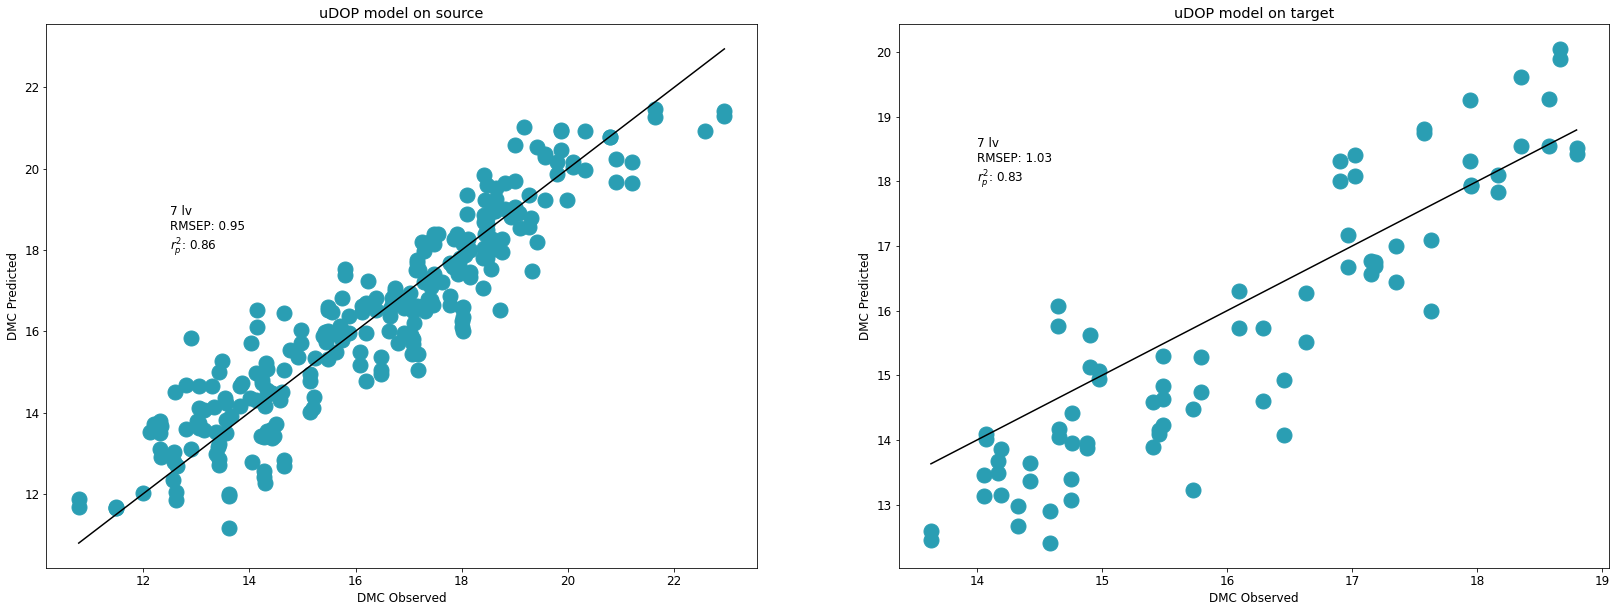

Property Model Orthogonalization Parameters  LV RMSECV  R2CV RMSEP (source)  \
0      DMC  uDOP                       3 comp   7   0.91  0.85           0.95   

  R2P (source) RMSEP (target) R2P (target)  
0         0.86           1.03         0.83

In [33]:

xcal_pls = Xsou_cal.dot(E_udop)
chosen_lv = udop_lv_chosen
orth_params = r'{:d} comp'.format(udop_comp_chosen)
type_model = "uDOP"


model_performance_output = get_mod_performance(xcal_pls, ycal_pls, chosen_lv, Xsou_test, Ysou_test, Xtar_test, Ytar_test, 
                        type_model,x_perf_s,y_perf_s,x_perf_t,y_perf_t, 
                                               n_splits_cv = n_splits_cv, 
                                               property_name = desc_format["Property"], orth_params = orth_params,
                                              save_file = "", fig_width = 28)

table_summary_performance[type_model] = model_performance_output.copy()


pd.DataFrame([model_performance_output])

In [34]:
df_perf = pd.DataFrame.from_dict(table_summary_performance, orient="index")
df_perf

Property     Model Orthogonalization Parameters  LV RMSECV  R2CV  \
Original      DMC  Original                         None   9   0.54  0.95   
TOP           DMC       TOP                       1 comp   8   0.54  0.95   
DOP           DMC       DOP         $\rho$ : 10 / 3 comp   6   0.56  0.94   
uDOP          DMC      uDOP                       3 comp   7   0.91  0.85   

         RMSEP (source) R2P (source) RMSEP (target) R2P (target)  
Original           0.57         0.95           1.50         0.76  
TOP                0.58         0.95           1.56         0.74  
DOP                0.62         0.94           1.01         0.81  
uDOP               0.95         0.86           1.03         0.83

# 3. Alignment of components uDOP

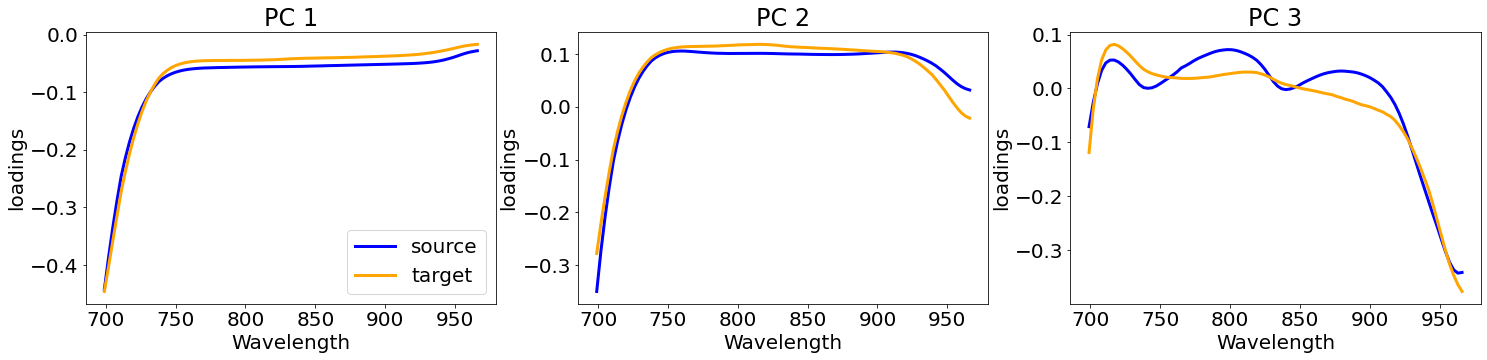

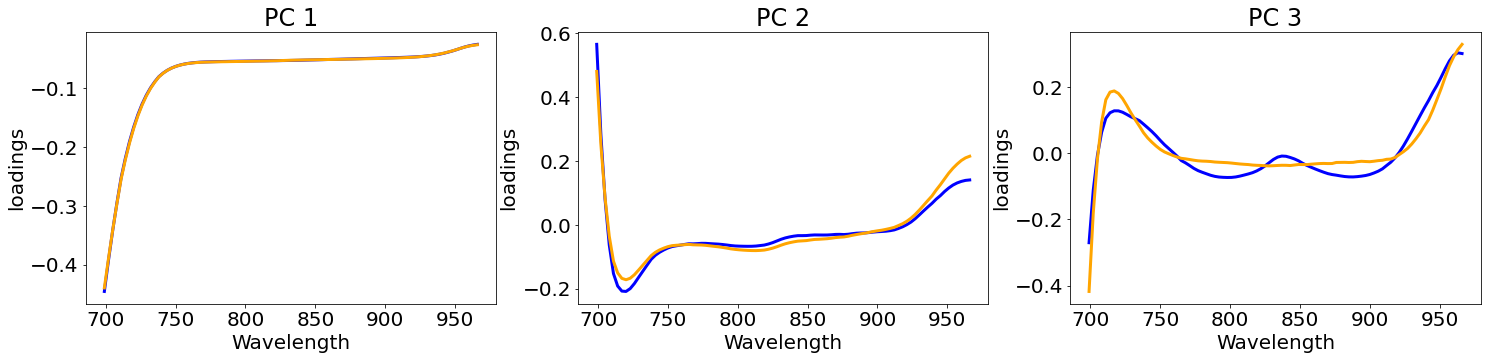

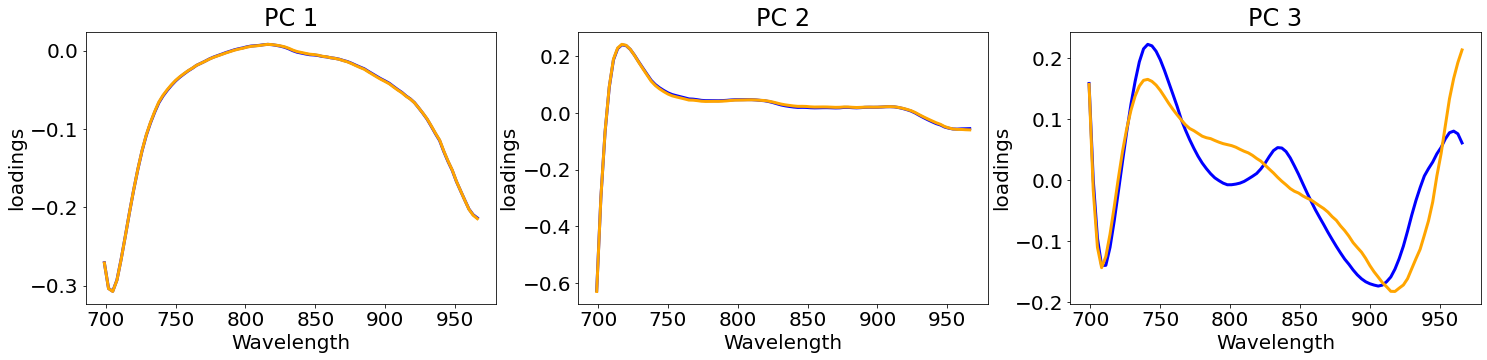

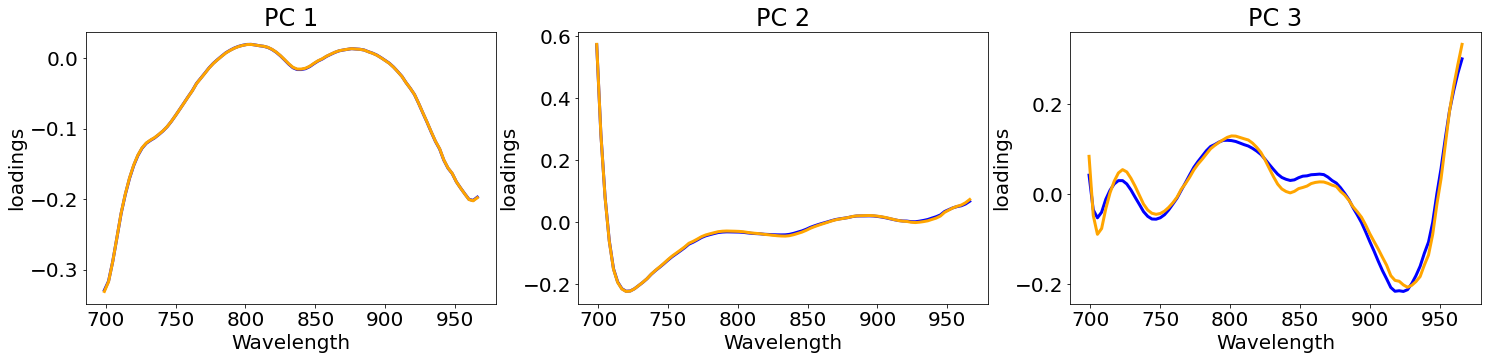

In [36]:
plt.rcParams.update({'font.size': 20})
Xsou_cal_udop = Xsou_cal.copy()
Xtar_cal_udop = Xtar_cal.copy()
svd_ncomp = 20

source_name = "source"
target_name = "target"

for di in range(0,4):
    
    
    
    E_udop_fig = ct.udop(Xsou_cal, Xtar_cal, udop_ncomp=di)
    Xsou_cal_udop = Xsou_cal.dot(E_udop_fig)
    Xtar_cal_udop = Xtar_cal.dot(E_udop_fig)
    Xconcat = np.concatenate((Xsou_cal_udop, Xtar_cal_udop), axis = 0)
    

    Us0, Ss0, Vs_t0 = np.linalg.svd(Xsou_cal_udop - Xsou_cal_udop.mean(axis=0))
    Ut0, St0, Vt_t0 = np.linalg.svd(Xtar_cal_udop - Xtar_cal_udop.mean(axis=0))
    U0, S0, V_t0 = np.linalg.svd(Xconcat - Xconcat.mean(axis=0))

    Vs_t = Vs_t0[0:svd_ncomp,:]
    Vsou = Vs_t.T

    Vt_t = Vt_t0[0:svd_ncomp,:]
    Vtar = Vt_t.T
    
    V_t = V_t0[0:svd_ncomp,:]
    V = V_t.T

    Vsou_s = ct.Vsou_sign(Vsou, Vtar, V)
    
    fig, ax = plt.subplots(1,3, figsize = (25,5))
    
    h = 1
    ax[0].plot(wv_range,Vsou_s[:,h-1], c = "blue",  linewidth = 3, label = source_name)
    ax[0].plot(wv_range,Vtar[:,h-1], c = "orange",  linewidth = 3, label = target_name)
    ax[0].set_xlabel("Wavelength")
    ax[0].set_ylabel("loadings")
    ax[0].set_title("PC " + str(h))
    
    if di==0:
        ax[0].legend()
        
    
    h = 2
    ax[1].plot(wv_range,Vsou_s[:,h-1], c = "blue",  linewidth = 3, label = source_name)
    ax[1].plot(wv_range,Vtar[:,h-1], c = "orange",  linewidth = 3, label = source_name)
    ax[1].set_xlabel("Wavelength")
    ax[1].set_ylabel("loadings")
    ax[1].set_title("PC " + str(h))
    
    h = 3
    ax[2].plot(wv_range,Vsou_s[:,h-1], c = "blue",  linewidth = 3, label = source_name)
    ax[2].plot(wv_range,Vtar[:,h-1], c = "orange",  linewidth = 3, label = source_name)
    ax[2].set_xlabel("Wavelength")
    ax[2].set_ylabel("loadings")
    ax[2].set_title("PC " + str(h))
    
    
    
    plt.show()



# Components of D

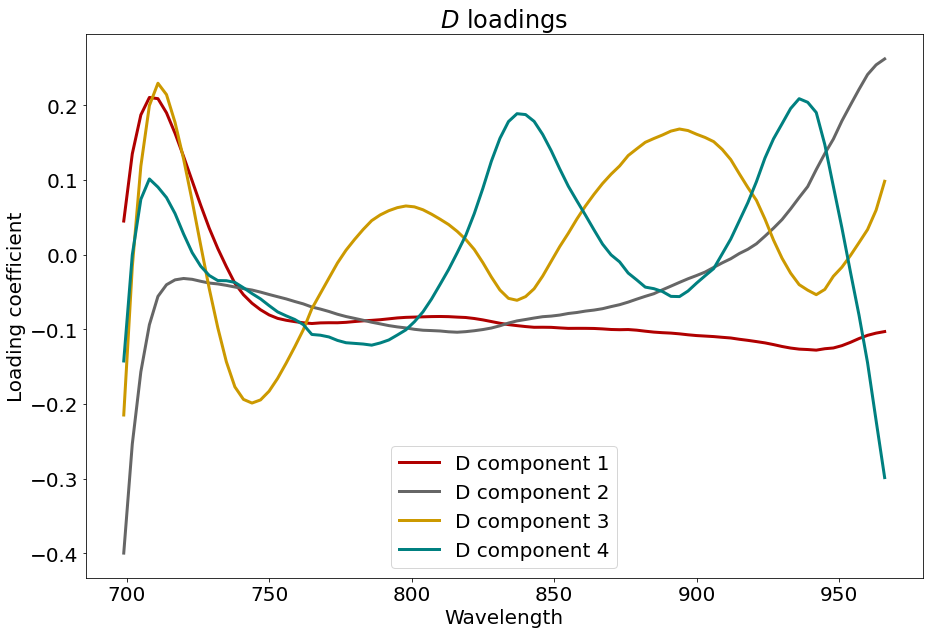

In [37]:
svd_ncomp = 20

Xsou_cal_udop = Xsou_cal.copy()
Xtar_cal_udop = Xtar_cal.copy()
Xconcat = np.concatenate((Xsou_cal_udop, Xtar_cal_udop), axis = 0)


epo_ncp = 4

Us0, Ss0, Vs_t0 = np.linalg.svd(Xsou_cal_udop - Xsou_cal_udop.mean(axis=0))
Ut0, St0, Vt_t0 = np.linalg.svd(Xtar_cal_udop - Xtar_cal_udop.mean(axis=0))
U0, S0, V_t0 = np.linalg.svd(Xconcat - Xconcat.mean(axis=0))



Vs_t = Vs_t0[0:svd_ncomp,:]
Vsou = Vs_t.T

Vt_t = Vt_t0[0:svd_ncomp,:]
Vtar = Vt_t.T

V_t = V_t0[0:svd_ncomp,:]
V = V_t.T


Vsou_s = ct.Vsou_sign(Vsou, Vtar, V)


Xtar_hat = (Xtar_cal_udop - Xtar_cal_udop.mean(axis=0)).dot(Vtar).dot(Vsou_s.T) + Xtar_cal_udop.mean(axis=0)

D = Xtar_cal_udop - Xtar_hat


U0,S,V0t = np.linalg.svd(D)
S_matrix = np.zeros((epo_ncp,epo_ncp))
S_matrix[0:epo_ncp,:][:,0:epo_ncp] = np.diag(S[0:epo_ncp])
V = V0t[0:epo_ncp].T

color = ["#B00000","#666666","#CC9900","#008080"]
plt.subplots(figsize = (15, 10))
for i in range(epo_ncp):
    plt.plot(wv_range, V[:,i], linewidth = 3, label = "D component " + str(i+1), c = color[i])
plt.legend(loc = 0)
plt.xlabel("Wavelength")
plt.ylabel("Loading coefficient")
plt.legend()
plt.title("$D$ loadings")

plt.show()
